# Race Audit (based on 2010 Census data collected)

In [7]:
# add path for python modules, this was needed for me since my venv didn't include my pip libraries
import sys
sys.path.append('c:\\users\\yeray lopez\\envs\\ssi_dni\\lib\\site-packages')

## Import modules

In [8]:
from ethnicolr import census_ln, pred_census_ln
from nameparser import HumanName
import pandas as pd
from pandas import DataFrame
import numpy as np
pd.set_option('display.max_rows', None)
from numpy.random import choice
import matplotlib.pyplot as plt

## Execute this cell if full names need to be parsed (if not skip) 

In [9]:
# Import list of full names
df = pd.read_csv("full_names_dummy_data.csv") # Enter path to desired CSV of full names here
df = df[['full_name']].copy()
df['first_name'] = df['full_name'].apply(lambda name: HumanName(name).first)
df['last_name'] = df['full_name'].apply(lambda name: HumanName(name).last)
df.to_csv('Parsed_Names.csv', index=False)

## Perform Race detection using ethnicolor 
## Import desired CSV that is formatted with "last_name" column

In [10]:
#Import desired CSV

df= pd.read_csv('Parsed_Names.csv')

In [11]:
# Perform race detection using 2010 census data 
df = census_ln(df, 'last_name',2010)

# Calculate number of undetectable last names
count_nan = len(df) - df.count()
num_unknowns = count_nan[3] # Note that the index can be 3-8 since they will return the same number
print("Names with no results:",num_unknowns) 

# Rows with unknown races are dropped
df = df.dropna() 

# Replace S for insignificant value. (0 isn't used since we cant divide by 0)
# S is part of ethnicolors internal return values
df = df.replace(['(S)'], 0.01)

# Display Results of Ethnicolor 
df.head()

Names with no results: 549


,full_name,first_name,last_name,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic
0,Huey Muschette,Huey,Muschette,0.01,94.74,0,0,3.07,0.01
1,Corny Seal,Corny,Seal,91.04,2.25,2.08,0.88,1.67,2.07
4,Aigneis Vanetti,Aigneis,Vanetti,97.27,0.01,0,0,0,0.01
5,Blondelle Casement,Blondelle,Casement,95.76,0,0.01,0.01,2.12,0.01
6,Gibb Weeks,Gibb,Weeks,84.38,9.97,0.55,0.84,1.81,2.45


## Calculate Race

In [12]:
# Find which is the highest percentage for each last name
def to_race(c):
    w = np.array(c).astype(float)
    probs = w/w.sum() 
    return choice(races, p=probs)

# Create rows for races
races = ['white', 'black', 'api', 'hispanic']

# Calculate Race using function
df['race'] = df[['pctwhite', 'pctblack', 'pctapi', 'pcthispanic']].apply(lambda c: to_race(c), axis=1)


## Results:

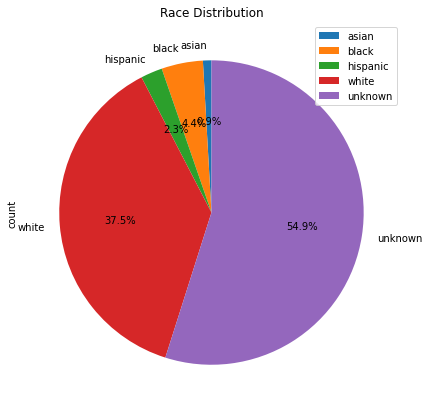

          count
race           
asian         9
black        44
hispanic     23
white       375
unknown     549


In [13]:
# Count
df['last_name'] = df.full_name.str.title()
df2 = df.groupby('race').agg({'last_name': 'count'})
df2.rename(columns={'last_name': 'count'},inplace = True)
df2.rename({'api': 'asian'},inplace = True)
df2.loc["unknown"] = [num_unknowns]

# Percentages
df3 = (100. * df2 / df2.sum())
df3.rename(columns={'count': 'percentages'},inplace = True)

# Plot Pie Chart
df4 = DataFrame(df2, columns = ['count'],index = ['asian','black','hispanic','white','unknown'])
df4.plot.pie(y='count',figsize=(7, 7),autopct='%1.1f%%', startangle=90,)
plt.title('Race Distribution')
plt.show()
print(df2)